In [8]:
import astropy.units as u
import astropy.constants as c
from astropy.modeling.physical_models import BlackBody
import numpy as np
import matplotlib.pyplot as plt

class SED:
    def __init__(self,mag,temperature,temp_units,wave_start,wave_stop,wave_units):
        
        self.mag = mag
        self.temperature = temperature
        if temp_units=='Kelvin':
            self.temperature = self.temperature*u.K
        self.wave_start = wave_start
        self.wave_stop = wave_stop
        if wave_units == "Angstrom":
            self.wave_start = self.wave_start*u.AA
            self.wave_stop = self.wave_stop*u.AA

            
            
    def create_spectrum(self):
        blackbody_model = BlackBody(self.temperature,scale=1*u.erg/u.s/u.cm**2/u.sr/u.AA)
        self.wavelength = np.linspace(self.wave_start,self.wave_stop,100000)
        self.model_spectrum = blackbody_model(self.wavelength)
        
        ref_spectrum = BlackBody(temperature=9700*u.K,scale=1*u.erg/u.s/u.cm**2/u.sr/u.AA)
        normalize = (3.63e-9*u.erg/u.cm**2/u.s/u.AA)/(ref_spectrum(5500*u.AA)*u.sr) 
        self.normalized_spectrum = self.model_spectrum*u.sr*normalize*10.**(-0.4*self.mag)
        return self.wavelength,self.normalized_spectrum
    
    
    def plot(self,plot):
        
        wavelength,normalized_spectrum = SED.create_spectrum(self)
        
        fig,ax = plt.subplots(1,1,figsize=(10,8))
        ax.set_xlabel('Wavelength ($\AA$)')
        ax.set_ylabel('Flux Density (ergs $s^{-1} cm^{-2} \AA^{-1}$)')
        ax.plot(np.linspace(self.wave_start,self.wave_stop,100000),normalized_spectrum)
            
        plt.show()

        
class BandPass:
    def __init__(self,filter,wavelength,normalized_spectrum):
        self.normalized_spectrum = normalized_spectrum
        self.wavelength = wavelength
        if filter=='V':
            self.filter_wavelength = np.arange(0,10000)
            self.filter = np.zeros(len(self.filter_wavelength))
            index = np.where((self.filter_wavelength>5075)&(self.filter_wavelength<5925))
            self.filter[index]=1
            

    def convolve_SED(self):
        
        interpolated_filter_values = np.interp(self.wavelength.value, self.filter_wavelength, self.filter)
        
        self.convolved_spectrum = self.normalized_spectrum*interpolated_filter_values
        return self.convolved_spectrum

C:\ProgramData\Anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


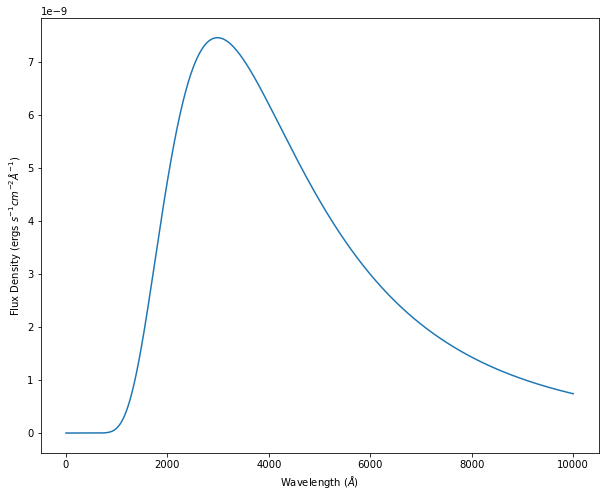

In [9]:
model = SED(mag=0,temperature=9700,temp_units='Kelvin',wave_start=1,wave_stop=10000,wave_units='Angstrom')

wavelength,normalized_spectrum = model.create_spectrum()
model.plot('Flux Density')


In [10]:
um = BandPass('V',wavelength,normalized_spectrum)

In [11]:
c = um.convolve_SED()

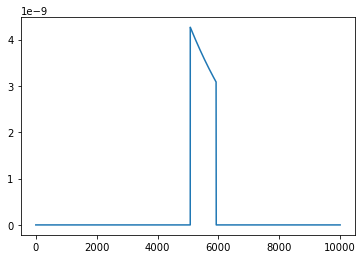

In [12]:
plt.plot(wavelength,um.convolved_spectrum)